### Kaggle mini project: Generating Monet-Style Images with GANs
The goal of this project is to develop a Generative Adversarial Network (GAN) that can produce 7,000 to 10,000 images in the distinctive artistic style of Claude Monet. The GAN will consist of a generator network that creates the images and a discriminator network that learns to distinguish between real Monet paintings and the generated fakes.

Basics of GANs
GANs (Generative Adversarial Networks) are two neural networks, a Generator and a Discriminator. The Generator creates fake data (e.g., images) from random noise while Discriminator tries to tell if a given data sample is real or fake (from the Generator). The Generator tries to fool the Discriminator, and the Discriminator tries to get better at spotting fakes. This interplay between them leads the Generator to create increasingly realistic data.

There are broadly two kinds of GANs
1. DCGAN (Deep Convolutional Generative Adversarial Networks)
DCGAN uses of deep convolutional neural networks (CNNs) for both the generator and discriminator. DCGAN replaces fully connected layers in a neural net with convolutional layers (specifically, transposed convolutions for the generator to "deconvolve" a latent vector into an image, and strided convolutions for the discriminator to downsample images), incorporating batch normalization, and using specific activation functions (ReLU for generator, LeakyReLU for discriminator).

2. CycleGAN (Cycle-Consistent Generative Adversarial Networks)
CycleGAN is a type of GAN designed for unpaired image-to-image translation. CycleGAN can learn to translate images between two domains (e.g., horses to zebras, or photos to paintings) without needing a one-to-one correspondence between images in the training data. It achieves this by employing two generator networks (one for each translation direction, e.g., Photo to Monet and Monet to Photo) and two discriminator networks (one for each domain). The crucial innovation is the cycle-consistency loss, which enforces that if an image is translated from domain A to domain B, and then translated back from domain B to domain A, it should ideally reconstruct the original image. This "round-trip" consistency helps the GAN learn meaningful mappings even without paired examples.

In [11]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from tensorflow.keras import layers, Model
from tqdm import tqdm
import random
from PIL import Image

import requests
from io import BytesIO
    
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(tf.__version__)

# DATA_PATH = "/kaggle/input/gan-getting-started"
monet_dir = os.path.join("data", "monet_tfrec")
photo_dir = os.path.join("data", "photo_tfrec")

2.19.0


In [12]:
#specify to work with cpu
# tf.config.set_visible_devices([], 'GPU')
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [13]:
def parse_image(example_proto):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    parsed = tf.io.parse_single_example(example_proto, features)
    img = tf.image.decode_image(parsed['image'], channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = (img * 2.0) - 1.0
    img.set_shape([None, None, 3])
    return img

def load_dataset(tfrecord_dir, batch_size=32, shuffle=True, buffer_size=1000):
    files = tf.io.gfile.glob(os.path.join(tfrecord_dir, '*.tfrec'))
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=tf.data.AUTOTUNE)
    ds = ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

monet_ds = load_dataset(monet_dir, batch_size=8)
photo_ds = load_dataset(photo_dir, batch_size=8)

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

#### Basic Inspection of images

2025-07-05 07:16:36.824123: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


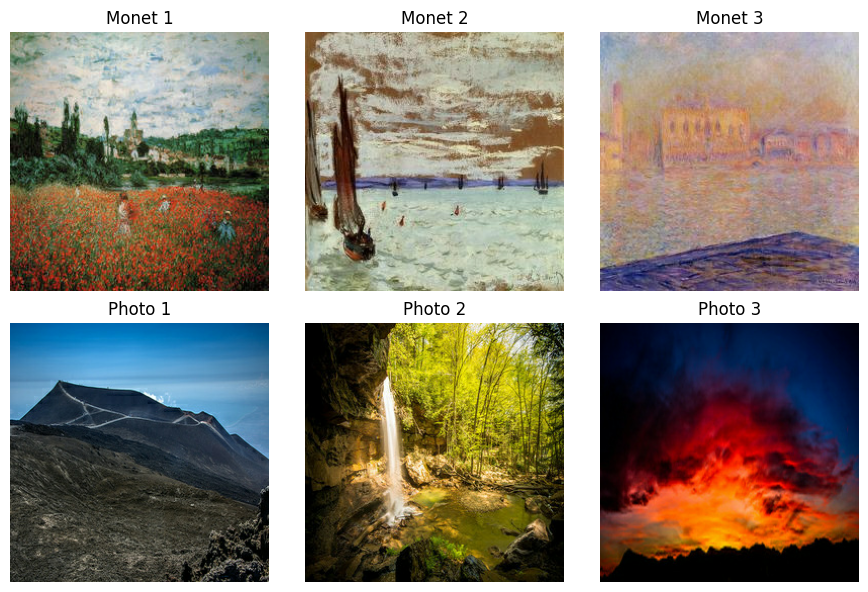

In [14]:
def load_images(tfrecord_dir, n=3):
    files = [os.path.join(tfrecord_dir, f) for f in os.listdir(tfrecord_dir) if f.endswith('.tfrec')]
    ds = tf.data.TFRecordDataset(files).map(
        lambda x: tf.io.parse_single_example(x, {'image': tf.io.FixedLenFeature([], tf.string)})
    )
    return [tf.image.decode_image(ex['image'].numpy(), channels=3) for ex in ds.take(n)]

monet_imgs = load_images(monet_dir)
photo_imgs = load_images(photo_dir)

fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for i in range(3):
    axes[0, i].imshow(monet_imgs[i].numpy())
    axes[1, i].imshow(photo_imgs[i].numpy())
    axes[0, i].set_title(f"Monet {i+1}")
    axes[1, i].set_title(f"Photo {i+1}")
    for ax in [axes[0, i], axes[1, i]]:
        ax.axis('off')

plt.tight_layout()
plt.show()

#### Modeling
Generator
The generator architecture is a U-Net-like convolutional neural network. It comprises an encoder, which is a downsampling path made of several downsample blocks utilizing strided convolutions, Instance Normalization, and Leaky ReLU activations to reduce spatial dimensions. This is followed by a decoder, an upsampling path consisting of upsample blocks that employ transposed convolutions, Instance Normalization, ReLU activations, and optional Dropout to increase spatial dimensions. Crucially, it incorporates skip connections that concatenate feature maps from corresponding encoder layers directly to the decoder layers, thereby preserving fine-grained spatial information. The network concludes with a final transposed convolutional layer using a tanh activation, outputting a 256x256x3 image with pixel values scaled to the range of -1 to 1.

Discriminator
The discriminator function constructs a PatchGAN discriminator, which takes a 256x256x3 image as input. It progressively downsamples this image using a series of convolutional layers, each followed by a Leaky ReLU activation and, for most layers, Instance Normalization. These convolutional layers use a 4x4 kernel with strides of 2 to reduce spatial dimensions, increasing the number of filters from 64 to 128 to 256. The final convolutional layer, with a single filter and a stride of 1, outputs a grid of values. Each value in this grid indicates the discriminator's confidence that a specific "patch" of the input image is real, thereby encouraging the generator to produce localized, realistic details.

In [15]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        result.add(layers.LayerNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    result.add(layers.LayerNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])
    
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4)
    ]

    up_stack = [
        upsample(256, 4, apply_dropout=True),
        upsample(128, 4, apply_dropout=True),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2,
                                  padding='same', kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)
    return Model(inputs=inputs, outputs=x)

In [16]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    
    x = inp
    x = layers.Conv2D(64, 4, strides=2, padding='same',
                      kernel_initializer=initializer)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False)(x)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False)(x)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(1, 4, strides=1, padding='same',
                      kernel_initializer=initializer)(x)
    return Model(inputs=inp, outputs=x)

In [17]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mae = tf.keras.losses.MeanAbsoluteError()

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)
    return (real_loss + fake_loss) * 0.5

def cycle_loss(real_image, cycled_image, lambda_cycle=10.0):
    return lambda_cycle * mae(real_image, cycled_image)

def identity_loss(real_image, same_image, lambda_identity=5.0):
    return lambda_identity * mae(real_image, same_image)

In [18]:
gen_G = build_generator()  # Monet → Photo
gen_F = build_generator()  # Photo → Monet
disc_X = build_discriminator()
disc_Y = build_discriminator()

generator_G_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_F_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [19]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = gen_G(real_x, training=True)
        cycled_x = gen_F(fake_y, training=True)
        fake_x = gen_F(real_y, training=True)
        cycled_y = gen_G(fake_x, training=True)

        # Identity mapping
        same_x = gen_F(real_x, training=True)
        same_y = gen_G(real_y, training=True)

        # Discriminator outputs
        disc_real_x = disc_X(real_x, training=True)
        disc_fake_x = disc_X(fake_x, training=True)

        disc_real_y = disc_Y(real_y, training=True)
        disc_fake_y = disc_Y(fake_y, training=True)

        # Losses
        gen_G_loss = generator_loss(disc_fake_y)
        gen_F_loss = generator_loss(disc_fake_x)
        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)
        total_gen_G_loss = gen_G_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_F_loss = gen_F_loss + total_cycle_loss + identity_loss(real_x, same_x)
        disc_X_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_Y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate and apply gradients
    generator_G_gradients = tape.gradient(total_gen_G_loss, gen_G.trainable_variables)
    generator_F_gradients = tape.gradient(total_gen_F_loss, gen_F.trainable_variables)

    discriminator_X_gradients = tape.gradient(disc_X_loss, disc_X.trainable_variables)
    discriminator_Y_gradients = tape.gradient(disc_Y_loss, disc_Y.trainable_variables)

    generator_G_optimizer.apply_gradients(zip(generator_G_gradients, gen_G.trainable_variables))
    generator_F_optimizer.apply_gradients(zip(generator_F_gradients, gen_F.trainable_variables))

    discriminator_X_optimizer.apply_gradients(zip(discriminator_X_gradients, disc_X.trainable_variables))
    discriminator_Y_optimizer.apply_gradients(zip(discriminator_Y_gradients, disc_Y.trainable_variables))


In [ ]:
def plot_example(randomness=False):
    to_monet = gen_F(example_photo)
    idx = 0
    if randomness:
        idx = random.randint(0, len(example_photo))
        
    plt.figure(figsize=(10, 5))
    for i, (title, img) in enumerate([
        ("Original Photo", example_photo[idx]),
        ("Monet-esque Photo", to_monet[idx])
    ]):
        plt.subplot(1, 2, i + 1)
        plt.imshow((img + 1) / 2.0)
        plt.title(title, fontsize=14)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [21]:
def train(dataset_monet, dataset_photo, epochs):
    for epoch in tqdm(range(epochs)):
        for monets, photos in tf.data.Dataset.zip((dataset_monet, dataset_photo)):
            train_step(monets, photos)

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(gen_G=gen_G, gen_F = gen_F,
                                 disc_X = disc_X, disc_Y = disc_Y,
                                 generator_G_optimizer=generator_G_optimizer, generator_F_optimizer=generator_F_optimizer, 
                                 discriminator_X_optimizer=discriminator_X_optimizer, discriminator_Y_optimizer=discriminator_Y_optimizer)

In [23]:
# restoring checkpoints after training on kaggle
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# actual training happened on kaggle
train(monet_ds, photo_ds, epochs=100)

8


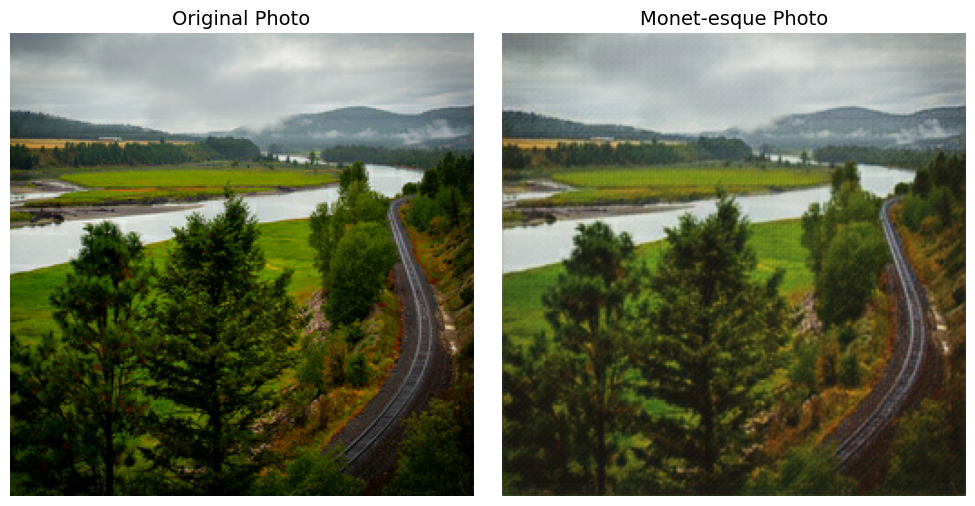

In [28]:
plot_example(randomness=True)

#### Results and Conclusion

My initial approach involved training a Deep Convolutional Generative Adversarial Network (DCGAN) to generate Monet-style images. Despite extensive training over numerous epochs(multiple days), the DCGAN architecture suffered significantly from mode collapse. This phenomenon manifested as a severe lack of diversity in the generated outputs, with the model consistently producing only a limited set of repetitive and undifferentiated images. Consequently, the DCGAN did not yield satisfactory results for this project's objective.

Following the challenges encountered with the DCGAN, I transitioned to implementing a Cycle-Consistent Generative Adversarial Network (CycleGAN). This architecture proved to be highly effective, successfully generating diverse and visually compelling images in the distinctive style of Claude Monet. The CycleGAN demonstrated a robust ability to translate source images into the target style, producing high-quality outputs that exhibited the desired artistic characteristics without suffering from mode collapse.